# Small Neural Network & Decision Tree

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree

import util.data_loading
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [23]:
# This is purely code cleaning and set up alr done previously

debt_df= util.data_loading.load_raw_data('debt_2003_2025 _clean.csv')
debt_df2= util.data_loading.load_raw_data('debt_pre_2003.csv')

debt_df2= util.data_loading.load_raw_data('debt_pre_2003.csv')
debt_df2 = debt_df2.T

debt_df2.columns = debt_df2.iloc[0]
debt_df2 = debt_df2[1:]

debt_df2 = debt_df2.reset_index()
debt_df2 = debt_df2.rename(columns={"index": "quarter"})

debt_df = util.data_loading.clean_dates(debt_df)
debt_df2 = util.data_loading.clean_dates(debt_df2)

debt_all = pd.concat(
    [debt_df2, debt_df],
    axis=0,          # stack rows
    ignore_index=True
)

house_all =  util.data_loading.load_raw_data('housing_units_all.csv')

median = util.data_loading.load_raw_data('MedianPricesofExistingDetachedHomesHistoricalData - Median Price.csv')
median_all  = util.data_loading.clean_median(median)

population = util.data_loading.load_raw_data('population_clean.csv')

ca_median = util.data_loading.get_median_prices(median_all,'CA')
ca_median = ca_median[(ca_median["Year"] >= 2000) & (ca_median["Year"] <= 2024)]
mortgage_debt =  util.data_loading.get_debt(debt_all,"Mortgage")
mortgage_debt = mortgage_debt[(mortgage_debt["Year"] >= 2000) & (mortgage_debt["Year"] <= 2024)]
mortgage_debt = mortgage_debt.apply(pd.to_numeric, errors="coerce")
debt_features = debt_all[["year", "Mortgage", "HE Revolving", "Auto Loan", 
                          "Credit Card", "Student Loan", "Other"]]
debt_features = debt_features.rename(columns={"year": "Year"})
debt_features = debt_features[(debt_features["Year"] >= 2000) & (debt_features["Year"] <= 2024)]
debt_features = debt_features.apply(pd.to_numeric, errors="coerce")

Looking for file at: C:\Users\krikr\CA_Housing_Analysis\data\debt_2003_2025 _clean.csv
Looking for file at: C:\Users\krikr\CA_Housing_Analysis\data\debt_pre_2003.csv
Looking for file at: C:\Users\krikr\CA_Housing_Analysis\data\debt_pre_2003.csv
Looking for file at: C:\Users\krikr\CA_Housing_Analysis\data\housing_units_all.csv
Looking for file at: C:\Users\krikr\CA_Housing_Analysis\data\MedianPricesofExistingDetachedHomesHistoricalData - Median Price.csv
Looking for file at: C:\Users\krikr\CA_Housing_Analysis\data\population_clean.csv


# Small Neural Network

Tiny Neural Network MSE: 1181424692.247607


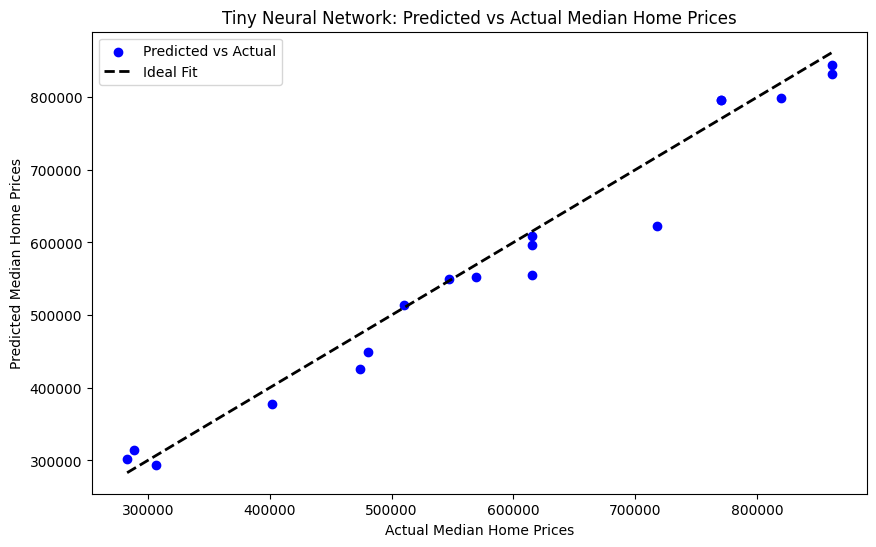

In [26]:
ca_units = util.data_loading.get_unit_estimates(house_all, "California")
ca_units = ca_units[(ca_units["Year"] >= 2000) & (ca_units["Year"] <= 2024)]
ca_units

population = population.rename(columns={"year": "Year"})
features = (
    ca_median.merge(debt_features, on="Year", how="inner")
             .merge(ca_units, on="Year", how="inner")
             .merge(population, on="Year", how="inner")
)
features = features.sort_values("Year")
features["CA_lag1"] = features["CA"].shift(1)
features = features.dropna().reset_index(drop=True)
X = features.drop(columns=["CA", "Year"])
y = features["CA"].values

# scale features

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42)

# small neural network model

tiny_neural = MLPRegressor(hidden_layer_sizes=(50, 50, 25), max_iter=5000, random_state=42)
tiny_neural.fit(X_train, y_train)
y_pred_tiny = tiny_neural.predict(X_test)

y_pred = scaler_y.inverse_transform(y_pred_tiny.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# evaluate model -> huge mse = bad/ overfitting model has not converged
# play around with hidden layers and iterations to reduce mse, if its too large like mine you can choose to add or remove StandardScaler step

mse_tiny = np.mean((y_test_original - y_pred) ** 2)
print(f"Tiny Neural Network MSE: {mse_tiny}")


# plotting predicting vs actual, unfortunately its underfitting a bit but line is close to ideal fit line
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Median Home Prices')
plt.ylabel('Predicted Median Home Prices')
plt.title('Tiny Neural Network: Predicted vs Actual Median Home Prices')
plt.legend()
plt.show()  

In [27]:

y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred_tiny.reshape(-1, 1)).flatten()

# RMSE
rmse = np.sqrt(np.mean((y_test_original - y_pred_original) ** 2))
print(f"RMSE: {rmse}")
# R² score
r2 = r2_score(y_test_original, y_pred_original)
print(f"R² score: {r2}")

RMSE: 34371.85901646297
R² score: 0.9655184809786873


# Feature Importance

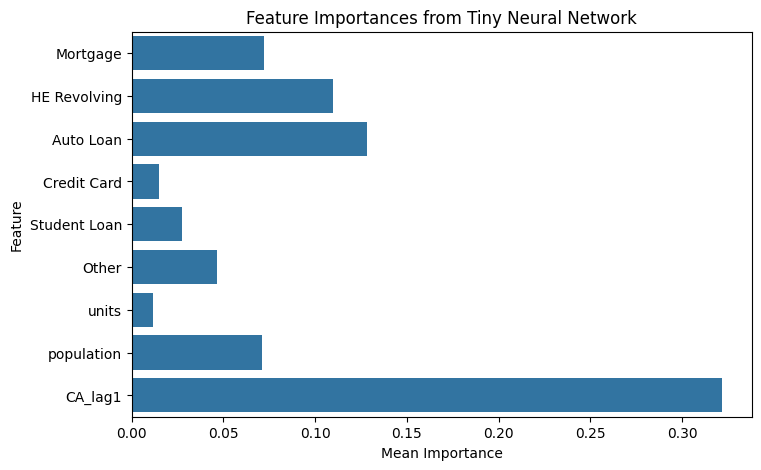

In [31]:
# Wanted to see which feature had more impact on the predictions by looking at feature importances

importance = permutation_importance(tiny_neural, X_test, y_test, n_repeats=30, random_state=42)
importances = importance.importances_mean

# prev only had mortgage debt as feature, now we have multiple debt features so we can compare
feature_cols = X.columns
feature_importance = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

# Plot feature importances
# as we can see wow mortage debt has the highest impact on the model predictions

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_cols)
plt.title('Feature Importances from Tiny Neural Network')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.show()


# Decision Tree

Decision Tree MSE: 0.02642183817776466
Decision Tree R2 Score: 0.9771180866195417


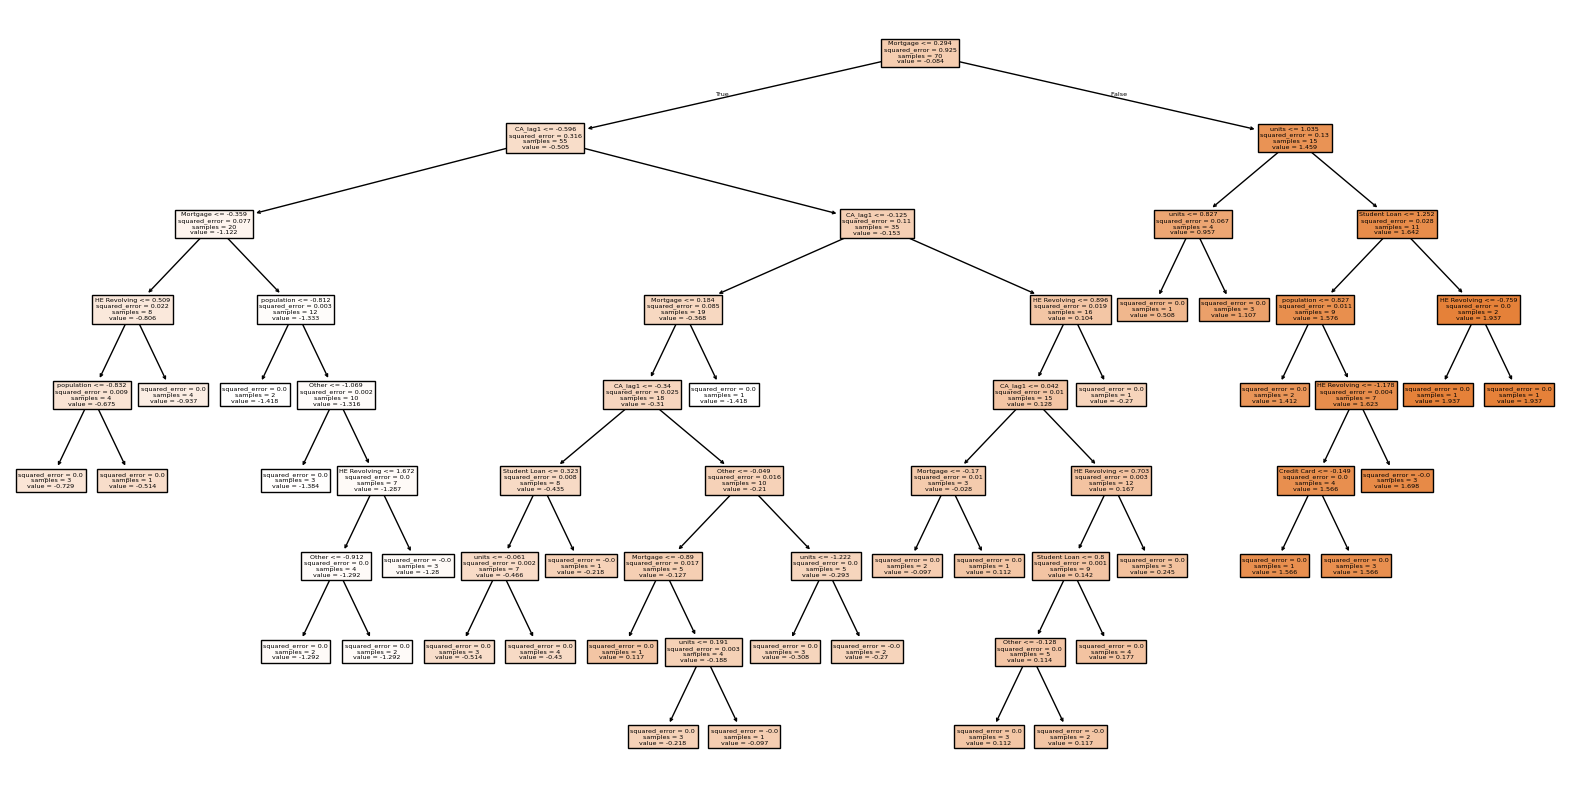

In [38]:
decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_tree = decision_tree.predict(X_test)

mse = mean_squared_error(y_test, y_pred_tree)
r2 = r2_score(y_test, y_pred_tree)
print(f"Decision Tree MSE: {mse}")
print(f"Decision Tree R2 Score: {r2}")
plt.figure(figsize=(20,10))
plot_tree(decision_tree, feature_names=feature_cols, filled=True)
plt.show()

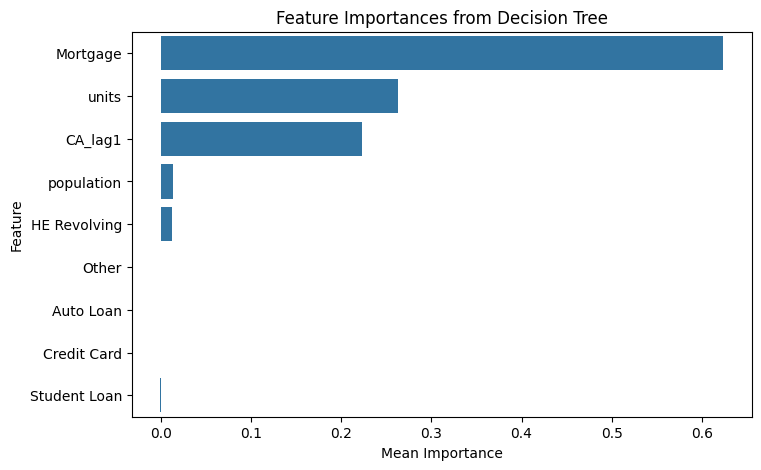

In [39]:
importance_tree = permutation_importance(decision_tree, X_test, y_test, n_repeats=30, random_state=42)
importances_tree = importance_tree.importances_mean

tree_feature_importance = pd.Series(importances_tree, index=feature_cols).sort_values(ascending=False)

# Plot feature importances for decision tree
plt.figure(figsize=(8, 5))
sns.barplot(x=tree_feature_importance.values, y=tree_feature_importance.index) 
plt.title('Feature Importances from Decision Tree')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.show()
